In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import datasets

# Load the training dataset
train_dataset = datasets.load_dataset("wmt16", "de-en", split="train[:50000]")

# Load the validation dataset
validation_dataset = datasets.load_dataset("wmt16", "de-en", split="validation")

# Load the test dataset
test_dataset = datasets.load_dataset("wmt16", "de-en", split="test")

In [3]:
source_lang = "de"
target_lang = "en"

In [4]:
# #convert from dataframe to list of tuples
# train_data, val_data, test_data = [], [], []
# prefix = "translate German to English: "
# for i in train_dataset["translation"]:
#     temp = []
#     temp.append(i["de"])
#     temp.append(i["en"])
#     temp = tuple(temp)
#     train_data.append(temp)

# for i in validation_dataset["translation"]:
#     temp = []
#     temp.append(i["de"])
#     temp.append(i["en"])
#     temp = tuple(temp)
#     val_data.append(temp)

# for i in test_dataset["translation"]:
#     temp = []
#     temp.append(i["de"])
#     temp.append(i["en"])
#     temp = tuple(temp)
#     test_data.append(temp)

In [5]:
prefix = "translate German to English:"

In [6]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [7]:
def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [8]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = validation_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

In [9]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

2024-04-02 12:06:27.601191: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 12:06:27.601244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 12:06:27.616743: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 12:06:28.166377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 12:06:30.618526: W tensorflow/compiler/

In [14]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [15]:
import evaluate

metric = evaluate.load("sacrebleu")

In [16]:
# import numpy as np

# def postprocess_text(preds, labels):
#     preds = [pred.strip() for pred in preds]
#     labels = [[label.strip()] for label in labels]

#     return preds, labels

# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     if isinstance(preds, tuple):
#         preds = preds[0]
#     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

#     #____________________________________________________________
#     # Calculate BLEU score
#     for i in range(4):
#         bleu_score = bleu.compute(predictions=decoded_preds, references=decoded_labels, max_order = i+1)
#         print(f"Bleu Score{i+1}: ", bleu_score)

#     # Calculate METEOR score
#     meteor_score = meteor.compute(predictions=decoded_preds, references=decoded_labels)

#     # Calculate BERTScore
#     bertscore_score = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang='en')

#     # print(f"BLEU Score: {bleu_score['bleu']}")
#     print(f"METEOR Score: {meteor_score}")
#     #print(f"BERTScore Score: {np.array(bertscore_score["precision"]).mean()}")
#     print(f"BERTScore Score: {np.array(bertscore_score['precision']).mean()}")

import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result


In [17]:
num_train_epochs=2
training_args = Seq2SeqTrainingArguments(
    output_dir="A3_T2C_Log",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,2.273500,2.127258,8.074600,16.911500
2,2.255300,2.113331,8.285300,16.910600


Checkpoint destination directory A3_T2C_Log/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory A3_T2C_Log/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory A3_T2C_Log/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/narotam21477/miniconda3/envs/prcly/lib/python3.11/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/narotam21477/miniconda3/envs/prcly/lib/python3.11/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` t

TrainOutput(global_step=6250, training_loss=2.28431328125, metrics={'train_runtime': 409.552, 'train_samples_per_second': 244.169, 'train_steps_per_second': 15.261, 'total_flos': 2700910596194304.0, 'train_loss': 2.28431328125, 'epoch': 2.0})

In [19]:
import torch

# Save the model
torch.save(model.state_dict(), "transformer_model_2C.pth")

In [ ]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [1]:
# # After training is done
# train_losses = trainer.state.log_history["train_loss"]
# eval_losses = trainer.state.log_history["eval_loss"]
train_losses = [2.273500, 2.255300]
eval_losses = [2.127258, 2.113331]

# Print or plot the losses
for epoch, (train_loss, eval_loss) in enumerate(zip(train_losses, eval_losses), 1):
    print(f"Epoch {epoch}: Train loss: {train_loss}, Eval loss: {eval_loss}")

Epoch 1: Train loss: 2.2735, Eval loss: 2.127258
Epoch 2: Train loss: 2.2553, Eval loss: 2.113331


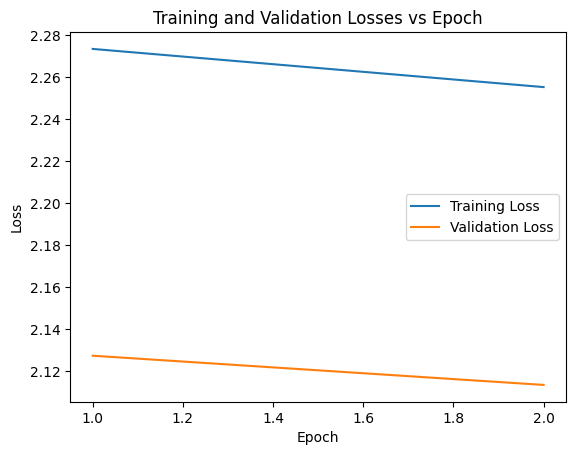

In [3]:
# Plotting training and validation losses vs epoch
import matplotlib.pyplot as plt
num_train_epochs = 2
plt.plot(range(1, num_train_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_train_epochs + 1), eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses vs Epoch')
plt.legend()
plt.show()

In [4]:
from transformers import pipeline

text = "translate German to English: Eine Katze sitzt auf der Matte."

translator = pipeline("translation", model="A3_T2C_Log")
translator(text)

OSError: A3_T2C_Log does not appear to have a file named config.json. Checkout 'https://huggingface.co/A3_T2C_Log/None' for available files.

In [8]:
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer
import torch

# Initialize the model architecture
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")

# Load the saved weights into the model
model.load_state_dict(torch.load("transformer_model_2C.pth",map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

# Example input text
input_text = "translate German to English: Eine Gruppe von Menschen steht vor einem Iglu."

# Tokenize the input text
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# Generate the translation
output_ids = model.generate(input_ids)

# Decode the generated output
translated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print the translated text
print("Translated Text:", translated_text)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Translated Text: A group of people is a glu.


In [12]:
import csv
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer
import torch

prefix = "translate German to English: "
# translator = pipeline("translation", model="A3_T2C_Log")

# def translate_sentence(transformer, german_sentence):
#     # Assuming translate function translates the given German sentence to English
#     translated_sentence = translate(transformer, german_sentence)
#     return translated_sentence

def translate_csv_file(model, input_csv_file, output_csv_file):
    with open(input_csv_file, 'r', encoding='utf-8') as input_file:
        csv_reader = csv.DictReader(input_file)
        rows = list(csv_reader)
        for i in rows:
               s = i["de"]
               i["de"] = prefix + s
        # print(rows)
    translated_rows = []
    for row in rows:
        german_sentence = row['de']
        # Example input text
        input_text = german_sentence

        # Tokenize the input text
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids

        # Generate the translation
        output_ids = model.generate(input_ids)

        # Decode the generated output
        translated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        row['en'] = translated_text
        translated_rows.append(row)

    with open(output_csv_file, 'w', newline='', encoding='utf-8') as output_file:
            fieldnames = ['de', 'en']
            csv_writer = csv.DictWriter(output_file, fieldnames=fieldnames)
            csv_writer.writeheader()
            csv_writer.writerows(translated_rows)





# Initialize the model architecture
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")

# Load the saved weights into the model
model.load_state_dict(torch.load("transformer_model_2C.pth",map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

german_sentence = "Eine Gruppe von Menschen steht vor einem Iglu."
# Example input text
input_text = german_sentence

# Tokenize the input text
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# Generate the translation
output_ids = model.generate(input_ids)

# Decode the generated output
translated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("Translated Sentence:", translated_text)

input_csv_file = "input_2A.csv"
output_csv_file = "output_task2C.csv"
translate_csv_file(model, input_csv_file, output_csv_file)
print("Translations saved to output.csv")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Translated Sentence: One group of people is a group of people who is a group of people who is
Translations saved to output.csv
